In [67]:
!pip install umap-learn

  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c41ade5fae974e36edf5d67c23e3047c1ae7283cb076eccc1b0586bfd6f42d30
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\f4\3e\1c\596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=989365fc0225ab044907084a083b9e28f0bec01e062d50a72d48928fd27f8fec
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\b9\89\cc\59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [68]:
!pip install hdbscan

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-win_amd64.whl size=602633 sha256=a360dd6eeca111e341aa15ebc714891804107193dbb35ffa70671a83f2177bc6
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\05\6f\88\1a4c04276b98306f00217a1e300e6ba0252c6aa4f7616067ae
Successfully built hdbscan


In [1]:
import pandas as pd
import numpy as np
import pymorphy2
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from rank_bm25 import BM25Okapi
from tqdm.notebook import tqdm
from typing import List, Tuple


import warnings
warnings.filterwarnings("ignore")

In [2]:
df_check = pd.read_excel('TenderHack_Moscow_test_data.xlsx')
df = pd.read_csv('data_clust.csv')

### Функции для предобработки

In [3]:
def lematize_text(text: str) -> str: 
    """
    Return lematizing text
    """
    return morph.parse(text)[0].normal_form

def lematize_corpus(texts: List[str]) -> List[str]: 
    """
    Return lematizing the list of strings
    """
    return [lematize_text(text) for text in texts]

def get_sim_df(df: pd.DataFrame, query: str):
    """
    return similarity dataframe
    """
    tokenized_query = lematize_text(query).split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    idx_sim = np.argsort(doc_scores)[::-1]
    sim_df = df.iloc[idx_sim]
    sim_df['sim_score'] = [doc_scores[i] for i in idx_sim]
    return sim_df

In [4]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


def predict(X_test): # X_test: str
    X_test = lematize_text(X_test).split(" ")
    embedding = tfid.transform([X_test])
    similarity_matrix = cosine_similarity(embedding, embeddings)
    return df.iloc[np.argsort(similarity_matrix)[:, ::-1][0]]

def get_embeddings(df):
    emb_col = 'Наименование КС'
    tfid = TfidfVectorizer()
    lem_texts = lematize_corpus(df[emb_col]) # лемматизация текста`

    embeddings=tfid.fit_transform(lem_texts)
    
    return embeddings

In [5]:
emb_col = 'Наименование КС'
morph = pymorphy2.MorphAnalyzer()
lem_texts = lematize_corpus(df[emb_col]) # лемматизация текста`

In [6]:
embeddings = get_embeddings(df_check)

In [7]:
import umap
import hdbscan

def generate_umap_embeddings(message_embeddings,
                      n_neighbors,
                      n_components, 
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))
    
    return umap_embeddings
    
def generate_clusters(umap_embeddings, min_cluster_size):

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [8]:
umap_embeddings = generate_umap_embeddings(embeddings, 12, 30, 42)

In [9]:
clusters = generate_clusters(umap_embeddings, 5)

In [10]:
df_check['cluster'] = clusters.labels_

In [11]:
df_check = df_check.rename(columns={'ИНН_хэш': 'ИНН', 'Unnamed: 0': 'id'})

In [12]:
df_check.to_csv('data_check_clust.csv', index=False)

In [8]:
df_check = pd.read_csv('data_check_clust.csv')

In [13]:
import joblib
filename_umap = 'umap_embeddings.sav'
filename_clust = 'hdbscan.sav'

# save models
#joblib.dump(umap.UMAP(), filename_umap)
#joblib.dump(hdbscan.HDBSCAN(), filename_clust)

#time passes 
loaded_reducer = joblib.load(filename_umap)
loaded_cluster_model = joblib.load(filename_clust)

In [9]:
df_check.head()

,id,Наименование КС,ОКПД 2,КПГЗ,Регион,НМЦК,Дата,ИНН,cluster
0,2,Баллон со сжатым воздухом OfficeClean 400мл,NaN,01.15.05.19,Москва,17500.0,2022-10-20 14:26:03.187,364ca6d24ba0fc3806aa71e61c345b26,550
1,10,Зеркало KD_ настенное Attache 1801 ВИ-1 вишня,NaN,01.20.12,Москва,16272.4,2021-04-20 09:12:13.480,7c0bd8d30ebea9cbef75e78329ba7e1f,956
2,14,ТОВАРЫ СТРОИТЕЛЬНЫЕ,NaN,01.11.03.01.01.99;01.11.04.02.04,Москва,21625.5,2022-10-11 14:07:04.233,08ee92d02740f330527552e14f5817f5,44
3,15,"СПЕЦИАЛЬНАЯ ЭКИПИРОВКА ДЛЯ БАСКЕТБОЛА, СТРИТБОЛА",NaN,01.08.02.19;01.08.02.19,Москва,105600.0,2022-05-11 12:52:07.587,f3a4e725256c4d5dcdc6c76a5b882e4f,-1
4,19,ТОВАРЫ СТРОИТЕЛЬНЫЕ,NaN,01.11.02.02.99;01.11.01.04.11;01.11.04.05;01.1...,Москва,37014.8,2021-03-01 09:07:14.213,e2e51398042af9c90eefb9e471d166c0,44


In [10]:
df = pd.read_csv('data_clust.csv')

In [11]:
df.head()

,id,Статус,Наименование КС,ОКПД 2,КПГЗ,Регион,НМЦК,Итоговая цена,Дата,Участники,Ставки,ИНН,Категория,Уникальные,cluster
0,0,Завершена,СТУЛЬЯ УЧЕНИЧЕСКИЕ,0,01.06.01.03.01;01.06.01.03.01,Москва,596790.0,593806.05,2021-06-30 11:20:05.720,1,1,d8912494ba2edd3bfeba55206a78a0f5,01.06.01.03.01;01.06.01.03.01,1,1152
1,1,Не состоялась,МЕДИЦИНСКИЕ РАСХОДНЫЕ МАТЕРИАЛЫ,0,01.02.10.50.33;01.02.10.43.05.01,Москва,4964.9,0.00,2022-10-04 09:16:04.770,0,0,237a5c57a66f02f8deb152e21f33863a,01.02.10.50.33;01.02.10.43.05.01,2,2593
2,3,Завершена,Видеокарта Palit PCI-E,0,01.13.17.08,Москва,462000.0,311850.00,2021-07-01 13:23:09.177,6,65,040f1570117a744d529f4675f827a50f,01.13.17.08,1,-1
3,4,Завершена,"ТОВАРЫ ИНФОРМАЦИОННО-ТЕХНОЛОГИЧЕСКИЕ, СРЕДСТВА...",0,01.13.11.03.02;01.13.04.04.06.05;01.10.04.04.0...,Москва,505555.0,460042.90,2021-03-16 10:42:20.810,6,18,c00c03dca0274fe43fc34e974434a927,01.13.11.03.02;01.13.04.04.06.05;01.10.04.04.0...,6,237
4,5,Завершена,Пинцет острый,0,01.02.10.06.48.04,Москва,2000.0,1980.00,2022-05-26 11:04:42.597,2,2,cc997efa7a6742b6119a3c253a084e80,01.02.10.06.48.04,1,-1


Генерация первого таргета - Спад 

In [12]:
#Price decline in currency and percentage decline during the quotation session
def decline(df : pd.DataFrame) -> pd.DataFrame:
    df['decline_percentage'] = ((df['НМЦК'] - df['Итоговая цена']) / df['НМЦК'])*100
    return df

In [13]:
def count_unique_category(dfka: pd.DataFrame):
    """
    Takes pandas DataFrame, unites 2 columns: 'ОКПД  2' and 'КПГЗ' into 1 named 
    'Категория' and counts unique categories in new column 
    """
    dfka['Категория'] = dfka['КПГЗ'].fillna('').astype(str) + dfka['ОКПД 2'].fillna('').astype(str)

    def split_count(s: str):
        """
        Counts unique values in string 
        """
        splitted = set(s.split(';'))
        return len(splitted)

    dfka['Уникальные'] = dfka['Категория'].apply(split_count)
    return dfka

In [14]:
def number_sessions(df: pd.DataFrame) -> pd.DataFrame:
    """
    number of sessions for the customer by TIN
    """
    temp = df.groupby('ИНН', as_index = False).id.count().sort_values(by = 'id', ascending = False).rename(columns = {'id' : 'number_sessions'})
    df = df.merge(temp, how = 'left', on = 'ИНН')
    return df

In [15]:
def sort_by_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    sort dataframe by dataframe
    """
    df['Дата'] = df['Дата'].astype("datetime64")
    return df.sort_values(by=['Дата'])

def get_type_day_week(number_day: int) -> bool:
    """
    return True if weekday
    return False if weekend
    """
    if number_day in [0, 1, 2, 3, 4]:
        return True
    else:
        return False
    
def get_quarter(month: int) -> int:
    if month in [1, 2, 3]:
        return 1
    if month in [4, 5, 6]:
        return 2
    if month in [7, 8, 9]:
        return 3
    if month in [10, 11, 12]:
        return 4
def get_date_features(df: pd.DataFrame):
    """
     create next features:
     year
     month
     day
     day of week: weekend, weekday
    """
    df['Дата'] = df['Дата'].astype("datetime64")
    df['year'] = df['Дата'].dt.year
    df['month'] = df['Дата'].dt.month
    df['day'] = df['Дата'].dt.day
    df['quarter'] = df['month'].apply(get_quarter)
    df['day_of_week'] = df['Дата'].dt.dayofweek.apply(get_type_day_week)

In [16]:
def inn_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes pandas DataFrame and returns DataFrame with mean decline percentage,
    mean amount of bids and amount of all sessions for each INN
    """
    t = df.groupby('ИНН', as_index=False) \
        .agg({'id': 'count', 'НМЦК': 'mean', 'Ставки': 'mean'}) \
        .rename(columns={'id': 'amount_session', 'НМЦК': 'mean_decline', 'Ставки': 'mean_bid'})
    df = df.merge(t, how='left', on='ИНН')
    return df

In [17]:
def type_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    change type of source data
    """
    object_cols = ['id', 'Регион', 'ИНН', 'year', 'month', 'day', 'day_of_week']
    num_cols = ['Уникальные', 'number_sessions']
    
    df[object_cols] = df[object_cols].astype('object')
    df[num_cols] = df[num_cols].astype('int64')
    return df

In [18]:
def set_means(df, df_main):
    df = df.merge(df_main[['ИНН', 'amount_session', 'mean_decline', 'mean_bid']].groupby('ИНН', as_index=False).first(), how='left', on='ИНН')
    return df

In [19]:
def get_stat_nmck(df, df_main):
    """
    calculate statistic
    """
    mean, median, std = df_main['НМЦК'].mean(), df_main['НМЦК'].median(), df_main['НМЦК'].std()
    df['НМЦК_mean'] = abs(df['НМЦК'] - mean)
    df['НМЦК_median'] = abs(df['НМЦК'] - mean)
    df['НМЦК_std'] = abs(df['НМЦК'] - std)

In [20]:
def preproc(df: pd.DataFrame):
    df = sort_by_data(df)
    get_date_features(df)
    df = number_sessions(df)
    count_unique_category(df)
    df = decline(df)
    df = type_data(df)
    df = inn_stats(df)
    get_stat_nmck(df, df)
    return df

def preproc_test(df: pd.DataFrame, df_main):
    df = sort_by_data(df)
    get_date_features(df)
    df = number_sessions(df)
    count_unique_category(df)
    df = decline(df)
    df = type_data(df)
    df = set_means(df, df_main)
    get_stat_nmck(df, df_main)
    return df

def preproc_check(df: pd.DataFrame, df_main):
    df = sort_by_data(df)
    get_date_features(df)
    df = number_sessions(df)
    count_unique_category(df)
    #df = decline(df)
    df = type_data(df)
    df = set_means(df, df_main)
    get_stat_nmck(df, df_main)
    return df

### Формируем трейн и валидацию

In [56]:
prep_df = preproc(df)
prep_check_df = preproc_check(df_check, prep_df)

In [57]:
y = prep_df[['decline_percentage', 'Участники']]
X_train, X_test, _, _ = train_test_split(df, y, test_size=0.05, random_state=42)

In [58]:
X_train = preproc(X_train)[prep_df.columns]
X_test = preproc_test(X_test, X_train)

In [59]:
X_train['Статус'] = X_train['Статус'].map({'Завершена': 0, 'Снята с публикации': 1, 'Не состоялась': 1, 'Активна': 1})
X_test['Статус'] = X_test['Статус'].map({'Завершена': 0, 'Снята с публикации': 1, 'Не состоялась': 1, 'Активна': 1})

In [60]:
y_train_status = X_train[['Статус']]
y_test_status = X_test[['Статус']]

y_train = X_train[['Участники', 'decline_percentage']]
y_test = X_test[['Участники', 'decline_percentage']]

In [61]:
#X_test = X_test.drop(['Ставки', 'Участники', 'Итоговая цена'], axis=1)

In [62]:
def get_means(row: pd.Series, df) -> np.array([int, int, int]):
    inn = row['ИНН']
    date = row['Дата']

    mean_data = inn_stats(df[df['Дата'] < date])
    df = df.merge(mean_data[['ИНН', 'amount_session', 'mean_decline', 'mean_bid']], how='left', on='ИНН')
    df = df.fillna(0)
    return df

In [63]:
def get_area(data: int) -> int:
    """
    generate feature for predict status value
    """
    if 215_142.195 >= data >= 132_200.54:
        return 0
    return 1

X_train['НМЦК_bin'] = X_train['НМЦК'].apply(get_area)

In [64]:
X_test['НМЦК_bin'] = X_test['НМЦК'].apply(get_area)

In [65]:
object_cols = ['id', 'Регион', 'ИНН', 'year', 'month', 'day', 'day_of_week', 'quarter', 'cluster', 'НМЦК_bin']
num_cols = ['НМЦК', 'Уникальные', 'number_sessions', 'amount_session', 'mean_decline', 'mean_bid', 'НМЦК_mean', 'НМЦК_median', 'НМЦК_std']
#num_cols = ['НМЦК', 'Уникальные', 'number_sessions', 'НМЦК_mean', 'НМЦК_median', 'НМЦК_std']
target_1 = 'decline_percentage'
target_2 = 'Участники'
target_status = 'Статус'

In [39]:
X_test[object_cols+num_cols]

,id,Регион,ИНН,year,month,day,day_of_week,quarter,cluster,НМЦК_bin,НМЦК,Уникальные,number_sessions,amount_session,mean_decline,mean_bid,НМЦК_mean,НМЦК_median,НМЦК_std
0,123044,Москва,08ee92d02740f330527552e14f5817f5,2021,1,11,True,1,5782,1,78750.00,1,265,265,131997.626226,41.377358,71610.324086,71610.324086,178619.995908
1,141553,Москва,4b5d0bf5b27b6c4f39c09c29fe470560,2021,1,11,True,1,2085,1,24167.65,11,130,130,111308.367385,28.415385,126192.674086,126192.674086,233202.345908
2,235412,Москва,f40f2caf0450919dee953fd314cf1224,2021,1,11,True,1,1110,1,9000.00,1,203,203,98181.337783,38.965517,141360.324086,141360.324086,248369.995908
3,231342,Москва,e73f79e66b3bb8f4d4f4630f4c1103fa,2021,1,11,True,1,5322,1,69300.00,1,377,377,183578.209496,28.649867,81060.324086,81060.324086,188069.995908
4,195939,Москва,d722c4756507df5d528f97388a9ee9be,2021,1,11,True,1,-1,1,8241.64,1,129,129,85297.905271,29.604651,142118.684086,142118.684086,249128.355908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227099,32590,Москва,e07e15f9a358f4c96df0a14c15ad21ab,2022,11,30,True,4,452,1,8900.00,2,57,57,98412.442807,22.982456,141460.324086,141460.324086,248469.995908
227100,168265,Москва,ba8093ccc9664f0831ed5e60f16a402a,2022,11,30,True,4,1468,1,24120.00,1,91,91,62777.600440,31.692308,126240.324086,126240.324086,233249.995908
227101,226676,Москва,2689d36c73a3296a56dc774551eb62cd,2022,11,30,True,4,127,1,236760.00,2,109,109,279503.083945,32.091743,86399.675914,86399.675914,20609.995908
227102,19809,Москва,94b87cfc77381050d34634b018e3294c,2022,11,30,True,4,-1,1,594000.00,1,75,75,77448.597600,37.800000,443639.675914,443639.675914,336630.004092


In [77]:
from catboost import CatBoostClassifier

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from catboost import Pool, cv

clf = CatBoostClassifier(iterations = 700,
                             learning_rate = 0.01,
                             depth = 6,
                             auto_class_weights='SqrtBalanced',
                             task_type = "GPU",
                             cat_features=object_cols)

clf.fit(X_train[object_cols+num_cols], y_train_status, verbose=True)

0:	learn: 0.6419027	total: 26.5ms	remaining: 13.2s
1:	learn: 0.6148055	total: 49.6ms	remaining: 12.4s
2:	learn: 0.5994954	total: 74.3ms	remaining: 12.3s
3:	learn: 0.5823980	total: 93.9ms	remaining: 11.6s
4:	learn: 0.5760957	total: 115ms	remaining: 11.4s
5:	learn: 0.5709769	total: 136ms	remaining: 11.2s
6:	learn: 0.5674042	total: 157ms	remaining: 11.1s
7:	learn: 0.5647593	total: 180ms	remaining: 11.1s
8:	learn: 0.5578815	total: 199ms	remaining: 10.9s
9:	learn: 0.5554894	total: 223ms	remaining: 10.9s
10:	learn: 0.5538422	total: 243ms	remaining: 10.8s
11:	learn: 0.5525073	total: 270ms	remaining: 11s
12:	learn: 0.5489825	total: 292ms	remaining: 10.9s
13:	learn: 0.5452368	total: 312ms	remaining: 10.8s
14:	learn: 0.5439700	total: 336ms	remaining: 10.9s
15:	learn: 0.5430460	total: 360ms	remaining: 10.9s
16:	learn: 0.5423178	total: 385ms	remaining: 10.9s
17:	learn: 0.5410739	total: 409ms	remaining: 11s
18:	learn: 0.5406117	total: 428ms	remaining: 10.8s
19:	learn: 0.5395380	total: 450ms	remaini

166:	learn: 0.5162524	total: 3.36s	remaining: 6.7s
167:	learn: 0.5162446	total: 3.38s	remaining: 6.68s
168:	learn: 0.5161607	total: 3.4s	remaining: 6.65s
169:	learn: 0.5161360	total: 3.42s	remaining: 6.64s
170:	learn: 0.5161212	total: 3.44s	remaining: 6.62s
171:	learn: 0.5160890	total: 3.46s	remaining: 6.59s
172:	learn: 0.5160252	total: 3.48s	remaining: 6.57s
173:	learn: 0.5160037	total: 3.5s	remaining: 6.55s
174:	learn: 0.5159707	total: 3.51s	remaining: 6.53s
175:	learn: 0.5158948	total: 3.53s	remaining: 6.5s
176:	learn: 0.5158477	total: 3.55s	remaining: 6.48s
177:	learn: 0.5158132	total: 3.57s	remaining: 6.46s
178:	learn: 0.5157866	total: 3.59s	remaining: 6.44s
179:	learn: 0.5157779	total: 3.61s	remaining: 6.42s
180:	learn: 0.5157684	total: 3.63s	remaining: 6.39s
181:	learn: 0.5157610	total: 3.65s	remaining: 6.37s
182:	learn: 0.5157183	total: 3.66s	remaining: 6.35s
183:	learn: 0.5156756	total: 3.68s	remaining: 6.32s
184:	learn: 0.5156117	total: 3.7s	remaining: 6.29s
185:	learn: 0.515

331:	learn: 0.5124067	total: 6.7s	remaining: 3.39s
332:	learn: 0.5123958	total: 6.72s	remaining: 3.37s
333:	learn: 0.5123803	total: 6.74s	remaining: 3.35s
334:	learn: 0.5123571	total: 6.76s	remaining: 3.33s
335:	learn: 0.5123265	total: 6.78s	remaining: 3.31s
336:	learn: 0.5122954	total: 6.8s	remaining: 3.29s
337:	learn: 0.5122733	total: 6.81s	remaining: 3.27s
338:	learn: 0.5122428	total: 6.83s	remaining: 3.24s
339:	learn: 0.5122353	total: 6.85s	remaining: 3.23s
340:	learn: 0.5122244	total: 6.87s	remaining: 3.2s
341:	learn: 0.5122242	total: 6.89s	remaining: 3.18s
342:	learn: 0.5122101	total: 6.91s	remaining: 3.16s
343:	learn: 0.5121858	total: 6.93s	remaining: 3.14s
344:	learn: 0.5121823	total: 6.95s	remaining: 3.12s
345:	learn: 0.5121269	total: 6.96s	remaining: 3.1s
346:	learn: 0.5121193	total: 6.98s	remaining: 3.08s
347:	learn: 0.5120535	total: 7s	remaining: 3.06s
348:	learn: 0.5120350	total: 7.01s	remaining: 3.04s
349:	learn: 0.5120163	total: 7.03s	remaining: 3.01s
350:	learn: 0.51200

494:	learn: 0.5102184	total: 9.86s	remaining: 99.6ms
495:	learn: 0.5102081	total: 9.87s	remaining: 79.6ms
496:	learn: 0.5101830	total: 9.9s	remaining: 59.7ms
497:	learn: 0.5101720	total: 9.92s	remaining: 39.8ms
498:	learn: 0.5101600	total: 9.93s	remaining: 19.9ms
499:	learn: 0.5101303	total: 9.95s	remaining: 0us


In [90]:
clf.save_model('clf_to_status.cbm')

In [67]:
from catboost import CatBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from catboost import Pool, cv

clf = CatBoostClassifier()      # parameters not required.
clf.load_model('clf_to_status.cbm')

In [68]:
X_test = X_train.copy()
y_test_status = y_train_status

In [69]:
y_pred_status = clf.predict(X_test[object_cols+num_cols])

In [70]:
y_pred_status

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [71]:
sum(y_pred_status == y_test_status.values.reshape(1, -1)[0])/y_pred_status.shape[0]

0.8528295406509793

In [72]:
pd.Series(y_pred_status.reshape(1, -1)[0]).value_counts()/y_pred_status.shape[0]

0    0.832394
1    0.167606
dtype: float64

In [74]:
from sklearn.metrics import roc_auc_score

print("ROC-AUC")
print(f"Качество на трейне: {roc_auc_score(y_train_status, clf.predict_proba(X_train[object_cols+num_cols])[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test_status, clf.predict_proba(X_test[object_cols+num_cols])[:, 1])}")

ROC-AUC
Качество на трейне: 0.8573027959157559
Качество на тесте: 0.8573027959157559


In [36]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

precision_train, recall_train, _ = precision_recall_curve(y_train_status, clf.predict_proba(X_train[object_cols+num_cols])[:, 1])
precision_test, recall_test, _ = precision_recall_curve(y_test_status, clf.predict_proba(X_test[object_cols+num_cols])[:, 1])

print("PR-AUC")
print(f"Качество на трейне: {auc(recall_train, precision_train)}")
print(f"Качество на тесте: {auc(recall_test, precision_test)}")

PR-AUC
Качество на трейне: 0.6266186333092412
Качество на тесте: 0.6266186333092412


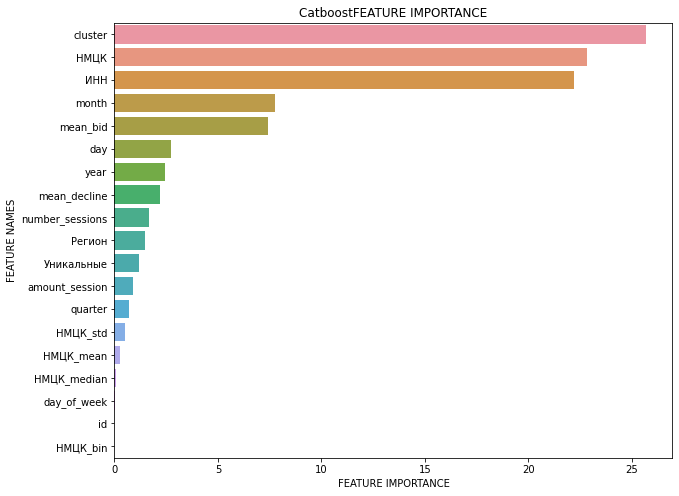

In [78]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance: np.array(int), names: List[str], model_type: str):
    """
    importance -> numeric value of features
    names -> features name
    model_type -> model name
    
    draw importance of features
    """
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(clf.feature_importances_, [object_cols+num_cols][0], 'Catboost')

In [79]:
from catboost import CatBoostRegressor
def pipeline_lvl_low(X_train, y_train, object_cols: List[str], num_cols: List[str], target_1: str):
    """
    data - Входные данные, на которых будет формироваться датасет, на котором модель будет обучаться
    object_cols - Категорильные колонки для модели
    num_cols - Категорильные вещественные для модели
    """
    model = CatBoostRegressor(iterations=500,
                          learning_rate=0.3,
                          depth=2,
                          cat_features=object_cols,
                          l2_leaf_reg = 1,
                          loss_function='MAE')
        
    #query = data[emb_col].values[0]
    #data_train = get_sim_df(prep_df, query)
    #return data_train
    X_train = X_train[['Статус'] + object_cols+num_cols]
    y_train = y_train[target_1]
    
    model.fit(X_train, y_train.values, verbose=False)
    return model

def pipeline_count_person(X_train, y_train, object_cols: List[str], num_cols: List[str], target_2: str):
    """
    data - Входные данные, на которых будет формироваться датасет, на котором модель будет обучаться
    object_cols - Категорильные колонки для модели
    num_cols - Категорильные вещественные для модели
    """
    model = CatBoostRegressor(iterations=500,
                          learning_rate=0.3,
                          depth=2,
                          cat_features=object_cols,
                          l2_leaf_reg = 1,
                          loss_function='MAE')
    
    #query = data[emb_col].values[0]
    #data_train = get_sim_df(prep_df, query)
    #return data_train
    X_train = X_train[['Статус'] + object_cols+num_cols]
    y_train = y_train[target_2]
    
    model.fit(X_train, y_train.values, verbose=False)
    return model

In [80]:
X_train['Статус'] = clf.predict(X_train[object_cols+num_cols])

model_lvl_low = pipeline_lvl_low(X_train[['Статус'] + object_cols+num_cols], y_train, object_cols, num_cols, target_1)
model_count_person = pipeline_lvl_low(X_train[['Статус'] + object_cols+num_cols], y_train, object_cols, num_cols, target_2)

In [92]:
model_lvl_low.save_model('model_lvl_low.cbm')
model_count_person.save_model('model_count_person.cbm')

In [81]:
def predict_(prep_df_check):
    dct = {'id': [],
           'Уровень снижения': [],
           'Участники': []}
    for i in tqdm(range(prep_df_check.shape[0])):
        idx = prep_df_check.iloc[i].id
        row = prep_df_check.iloc[[i]][object_cols+num_cols]
        row['Статус'] = clf.predict(row)[0]
        lvl_low = model_lvl_low.predict(row[['Статус'] + object_cols+num_cols])
        count_person = model_count_person.predict(row[['Статус'] + object_cols+num_cols])
        dct['id'].append(idx)
        dct['Уровень снижения'].append(lvl_low[0])
        dct['Участники'].append(count_person[0])
    return pd.DataFrame(dct)

In [84]:
predict_data = predict_(X_test.iloc[:10000])
predict_data

  0%|          | 0/10000 [00:00<?, ?it/s]

,id,Уровень снижения,Участники
0,123044,20.058168,5.285368
1,141553,9.399644,2.467247
2,235412,28.719892,6.163855
3,231342,26.038335,7.304685
4,195939,10.591352,3.043594
...,...,...,...
9995,219766,11.977383,6.177401
9996,266749,14.224301,2.240972
9997,148095,20.689624,5.531681
9998,226994,24.894654,4.009384


In [80]:
predict_data.to_csv('GENERAL_1384063_TenderHack_Moscow.csv', sep=';', index=False)

In [86]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test['decline_percentage'].iloc[:10000], predict_data['Уровень снижения'])

31.45238635463771

In [288]:
mean_absolute_error(y_test['Участники'], predict_data['Участники'])

1.8089219175568967

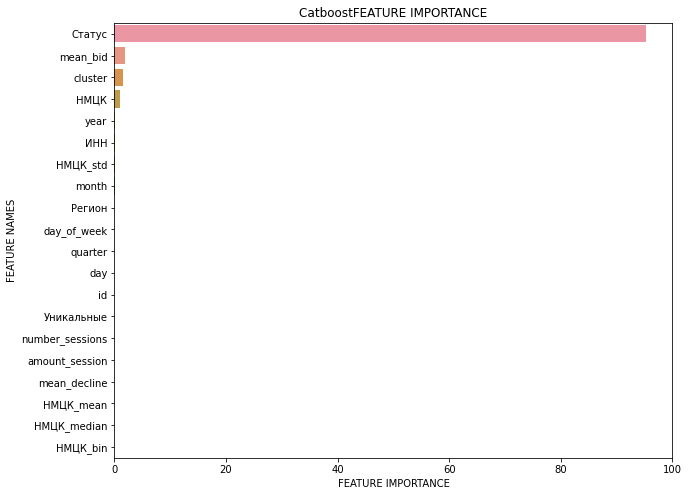

In [77]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance: np.array(int), names: List[str], model_type: str):
    """
    importance -> numeric value of features
    names -> features name
    model_type -> model name
    
    draw importance of features
    """
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model_lvl_low.feature_importances_, [['Статус']+object_cols+num_cols][0], 'Catboost')

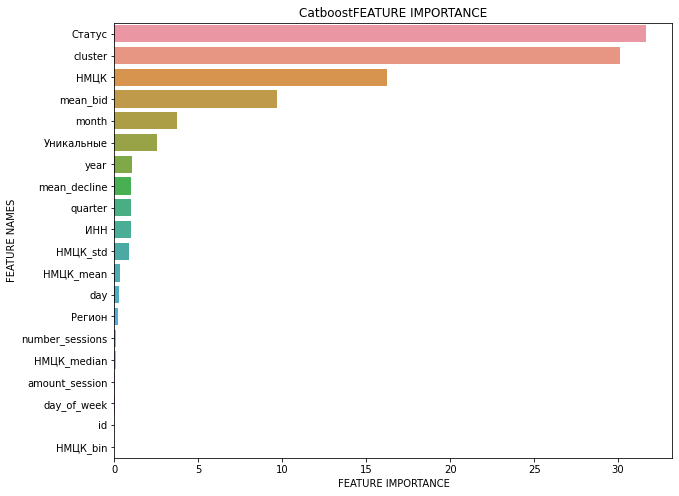

In [38]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance: np.array(int), names: List[str], model_type: str):
    """
    importance -> numeric value of features
    names -> features name
    model_type -> model name
    
    draw importance of features
    """
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model_count_person.feature_importances_, [['Статус']+object_cols+num_cols][0], 'Catboost')